In [1]:
import SimpleITK as sitk
import numpy as np
import h5py
import os
from numpy.random import default_rng

import matplotlib.pyplot as plt


# generate .nii.gz images
oai_folder = '/playpen-raid/qinliu/data/OAI/oai_cropped_320'
oai_ood_folder = '/playpen-raid/qinliu/data/OAI/oai_cropped_320_ood'

oai_image_name = '9292027r_0.h5'
oai_ood_image_name = '9291078r_4.h5'

In [2]:
output_folder = '/playpen-raid/qinliu/data/OAI/temp_mask'
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

oai_file_name = os.path.join(oai_folder, oai_image_name)
with h5py.File(oai_file_name, 'r') as data:
    image = data['reconstruction_esc']
    image_itk = sitk.GetImageFromArray(image)
    sitk.WriteImage(image_itk, os.path.join(output_folder, '{}.nii.gz'.format(oai_image_name)))

oai_ood_file_name = os.path.join(oai_ood_folder, oai_ood_image_name)
with h5py.File(oai_ood_file_name, 'r') as data_ood:
    image_ood = data_ood['reconstruction_esc']
    image_itk_ood = sitk.GetImageFromArray(image_ood)
    sitk.WriteImage(image_itk_ood, os.path.join(output_folder, '{}.nii.gz'.format(oai_ood_image_name)))

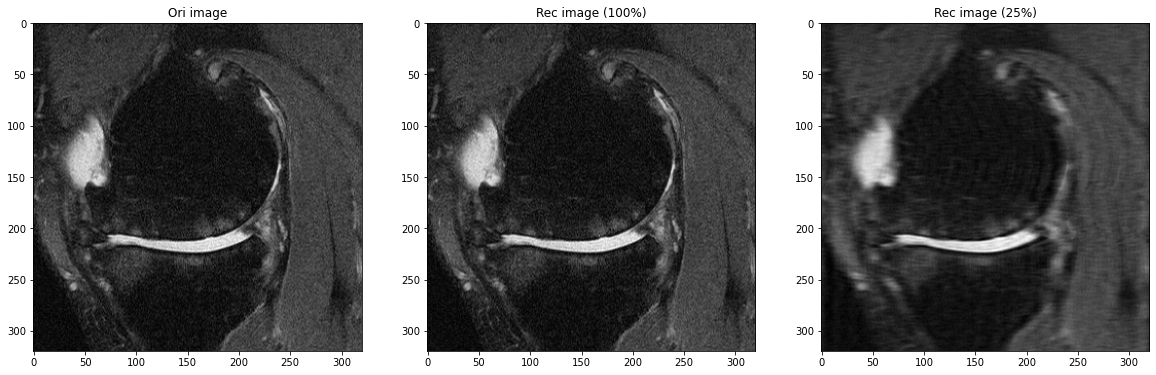

In [3]:
slice_idx = 10
with h5py.File(oai_ood_file_name, 'r') as data:
    image_ori = data['reconstruction_esc']
    kspace = data['kspace']

    # display a slice
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.title('Ori image')
    plt.imshow(image_ori[slice_idx], cmap='gray')

    plt.subplot(132)
    plt.title('Rec image (100%)')
    image = np.fft.ifftshift(kspace, axes=(1,2))
    image = np.fft.ifft2(image)
    image = np.fft.ifftshift(image, axes=(1,2))
    image_rec = []
    for i in range(image.shape[0]):
        image_slice = np.linalg.norm(np.stack([image[i].real, image[i].imag], axis=-1), axis=2)
        image_rec.append(image_slice)
    image_rec = np.stack(image_rec, axis=0)
    plt.imshow(image_rec[slice_idx], cmap='gray')

    plt.subplot(133)
    plt.title('Rec image (25%)')

    mask = np.zeros(kspace.shape)
    rng = default_rng()
    mask[:, :, 140:180] = 1
    numbers_low = rng.choice(range(0, 140), size=20, replace=False)
    numbers_high = rng.choice(range(180, 320), size=20, replace=False)
    for n in list(numbers_low) + list(numbers_high):
        mask[:, :, n] = 1
    kspace_masked = mask * kspace
    image_masked = np.fft.ifftshift(kspace_masked, axes=(1,2))
    image_masked = np.fft.ifft2(image_masked)
    image_masked = np.fft.ifftshift(image_masked, axes=(1,2))

    image_masked_rec = []
    for i in range(image.shape[0]):
        image_slice = np.linalg.norm(np.stack([image_masked[i].real, image_masked[i].imag], axis=-1), axis=2)
        image_masked_rec.append(image_slice)
    image_masked_rec = np.stack(image_masked_rec, axis=0)
    plt.imshow(image_masked_rec[slice_idx], cmap='gray')

    image_itk_masked = sitk.GetImageFromArray(image_masked_rec)
    sitk.WriteImage(image_itk_masked, os.path.join(output_folder, '{}_masked.nii.gz'.format(oai_ood_image_name)))




In [4]:
import ants

moving_image_path = os.path.join(output_folder, '9292027r_0.h5_masked.nii.gz')
fixed_image_path = os.path.join(output_folder, '9292027r_0.h5.nii.gz')

# moving_image_path = os.path.join(output_folder, '9291078r_4.h5_masked.nii.gz')
# fixed_image_path = os.path.join(output_folder, '9291078r_4.h5.nii.gz')


moving_image = ants.image_read(moving_image_path)
fixed_image = ants.image_read(fixed_image_path)

print(moving_image.shape, fixed_image.shape)

(320, 320, 37) (320, 320, 37)


In [5]:
reg_aff = ants.registration(moving=moving_image, fixed=fixed_image, type_of_transform='SyN')
print(reg_aff)

{'warpedmovout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (320, 320, 37)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'warpedfixout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (320, 320, 37)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'fwdtransforms': ['/tmp/tmphue2ul4i1Warp.nii.gz', '/tmp/tmphue2ul4i0GenericAffine.mat'], 'invtransforms': ['/tmp/tmphue2ul4i0GenericAffine.mat', '/tmp/tmphue2ul4i1InverseWarp.nii.gz']}


In [6]:
jac = ants.create_jacobian_determinant_image(fixed_image, reg_aff['fwdtransforms'][0], 1)
print(jac)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (320, 320, 37)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]



In [165]:
slice_id = 10
moving_image_slice = ants.from_numpy(moving_image[:,:,slice_id])
fixed_image_slice = ants.from_numpy(fixed_image[:, :, slice_id])
reg_aff_slice = ants.registration(
    moving=moving_image_slice, 
    fixed=fixed_image_slice,
    flow_sigma=2.0, 
    type_of_transforms='SyN')

jac_slice = ants.create_jacobian_determinant_image(fixed_image_slice, reg_aff_slice['fwdtransforms'][0], 1)


/playpen-raid/qinliu/tools/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



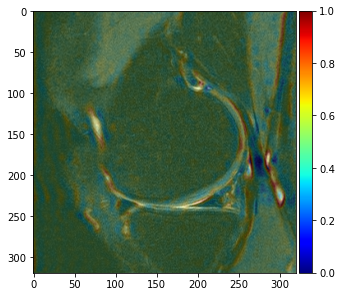

In [179]:
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

fixed_image_slice_npy = fixed_image_slice.numpy().transpose()
fixed_image_slice_norm = (fixed_image_slice_npy - np.min(fixed_image_slice_npy)) / \
    (np.max(fixed_image_slice_npy) - np.min(fixed_image_slice_npy))

img = np.float32(fixed_image_slice_norm)

max_val, min_val = 0.6, -0.6
jac_slice_npy = np.transpose(jac_slice.numpy())
jac_slice_npy_norm = (jac_slice_npy - min_val) / (max_val - min_val)

heat_map = cv2.applyColorMap(np.uint8(255 * (1 - jac_slice_npy_norm)), cv2.COLORMAP_JET)
heat_map = np.float32(heat_map) / 255

img_overlay = img_rgb + heat_map * 0.35
img_overlay = img_overlay / np.max(img_overlay)

# Plot for normal case
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(img_overlay, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
plt.show()